# Starbucks Capstone Project

## Overview
 
This capstone project is using data provided by Udacity as part of the Data Scientist Nanodegree course. It contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. The provided background information on the mobile app is that once every few days, Starbucks sends out an offer to users of the mobile app. Some users might not receive any offer during certain weeks, and not all users receive the same offer.

I use machine learning classification models to uncover the feature importances to identify the drivers of offer effectiveness, while exploring if the model itself could be used to predict if a user would take up an offer. In addition, I explore the characteristics of users who do or do not take up an offer. For instance, a user could receive a BOGO (buy one get one free) offer on Monday. The offer is valid for 7 days from receipt. If the customer buys a product during the validity period, the customer completes the offer. However, there are a few things to watch out for in these datasets. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the BOGO offer, but the user never opens the offer during the 7 day validity period. 


## Objectives

There are two main questions that I try to answer in this capstone project as follow

1. What are the main drivers of an effective offer on the Starbucks app? 
2. Could the data provided, namely offer characteristics and user demographics, predict whether a user would take up an offer?


## Datasets

There are three datasets provided in this project:
- portfolio.json: Containing the attributes of each offer (duration, type, etc.)
- profile.json: Demographic data for each customer
- transcript.json: Records for transactions, offers received, offers viewed, and offers completed

Note: This datasets are the simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

## Classification models

Using the data provided, I answer the main questions using three supervised classification machine learning models, feeding in the data from three different offer types. Using this way, the model can predict whether the offer will be responded by the customers or not when sent to them. Also, by checking the feature importance of the model, we can answer the question that what factors are main for an offer to be effective. The classification models used in this projects are "decision tree classifier", "random forest classifier", and "regression model".

### Import the libraries and packages, and load the datasets

In [4]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# read the datasets which are the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

In [5]:
from time import time
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

# Data Exploration
In order to analyze the problem better in next sections, first need to explore the datasets which includes checking the missing value, visualizing the data distribution, etc. In that way, we can have a better understanding on how the dataset looks like and how we cam featurize the data to make it ready for modelling


## 1. Portfolio Dataset

According to the information provided by Udacity, the schema is as follows:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - 
* channels (list of strings)

In [7]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


- The duration is not explained but I assumed from context that it is in terms of number of days.

- We can note that scale of each feature is different, for example the difficulty is in terms of dollars while the duration is in terms of days. Hence, some feature scaling will need to be done.

In [8]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


- As shown above there is no missing values

In [9]:
portfolio.id.nunique()

10

- As seen, there are 10 different types of offers disbursed to the customers by starbucks

In [10]:
# Offers of each type
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

- There are 3 types of offers : BOGO, Discount and Informational which is further subcategorised based on difficulty and duration.

In the feature engineering step we will convert the channels column into one-hot encoded feature

In [11]:
## Converting id column to offer_id

portfolio.rename(columns={'id':'offer_id'},inplace=True)
portfolio.head()

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


## 2. Profile Dataset

`profile` dataset provides the demographic data for customers as follows: 

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

It is also relatively straightforward, as it contains the demographic profile on the customer.

In [12]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [13]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [14]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

As we can see that there are null values in gender and income column. On further exploration it was found that the null values appear in both the columns for same rows. Therefore we can discard them.

In [15]:
#Age Column
profile[profile.age == 118][['gender','age','income']]

,gender,age,income
0,None,118,NaN
2,None,118,NaN
4,None,118,NaN
6,None,118,NaN
7,None,118,NaN
...,...,...,...
16980,None,118,NaN
16982,None,118,NaN
16989,None,118,NaN
16991,None,118,NaN


As we can observe that age value is 118 for all columns where null value is there in gender and income and hence we can directly drop and clean these rows.

In [16]:
# No of unique users
profile.id.nunique()

17000

In [17]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

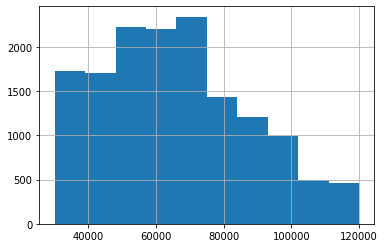

In [18]:
# distribution of income
profile.income.hist();

C:\Users\farhad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\farhad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


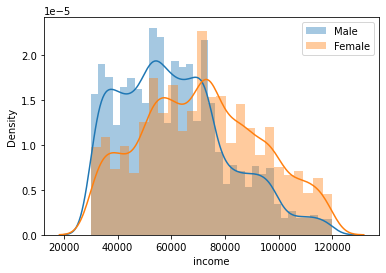

In [19]:
## Gender-wise Income Distribution
sns.distplot(profile[profile.gender=='M'].income,label='Male')
sns.distplot(profile[profile.gender=='F'].income,label='Female')
plt.legend()
plt.show()

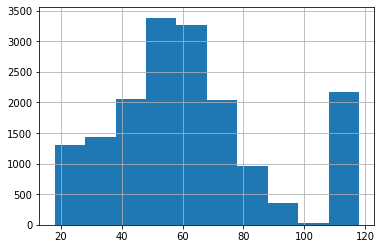

In [20]:
# age distribution
profile.age.hist();

We can clearly deduce here that 118 is an outlier as it doesn't follow the normal distribution

C:\Users\farhad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\farhad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


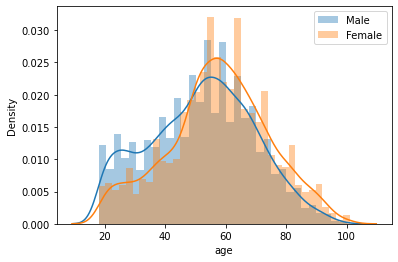

In [21]:
## Gender-wise age distribution
sns.distplot(profile[profile.gender=='M'].age,label='Male')
sns.distplot(profile[profile.gender=='F'].age,label='Female')
plt.legend()
plt.show()

The "became_member_on column" can be feature engineered to get the tenure of membership in days.

In [22]:
profile.became_member_on.head()

0    20170212
1    20170715
2    20180712
3    20170509
4    20170804
Name: became_member_on, dtype: int64

## 3. Transcript dataset

The schema for the transactional data is as follows:

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [23]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


- This data looks a bit more tricky, as it is ordered by time and has an event and value. In particular, the value column will have to be preprocessed depending on the event.

In [24]:
# quick check on missing value
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

- No Null Values

In [25]:
#event distribution
transcript.groupby('event').person.count()

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: person, dtype: int64

In [26]:
# extract the different values in value column out
transcript = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
transcript.head()

,person,event,value,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


It appears as though the offer id column ended up being duplicates so we have to clean it up further to ensure there is only one offer id column.

In [27]:
# clean up the duplicates in offer id and offer_id and meger into one column
transcript['clean_id'] = np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(), transcript['offer_id'],transcript['offer id'])

# drop the original id columns
transcript.drop(['offer id', 'offer_id'], axis=1, inplace=True)

# rename the offer_id column
transcript.rename(columns={'clean_id': 'offer_id'}, inplace=True)

In [28]:
# quick check on cleaned dataframe
transcript.head()

,person,event,value,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [29]:
transcript.offer_id.nunique()

10

In [30]:
transcript.person.nunique()

17000

Number of people in transcript are the same as the number of people in the Demographics Data

In [31]:
temp = pd.merge(transcript,portfolio,how='left',on='offer_id')
temp.head()

,person,event,value,time,amount,reward_x,offer_id,reward_y,channels,difficulty,duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,"[web, email, mobile]",5.0,7.0,bogo
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,"[web, email]",20.0,10.0,discount
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,"[web, email, mobile]",10.0,7.0,discount
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0,"[web, email, mobile, social]",10.0,10.0,discount
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,"[web, email, mobile, social]",10.0,5.0,bogo


In [32]:
temp.groupby(['offer_type','event']).person.count()

offer_type     event          
bogo           offer completed    15669
               offer received     30499
               offer viewed       25449
discount       offer completed    17910
               offer received     30543
               offer viewed       21445
informational  offer received     15235
               offer viewed       10831
Name: person, dtype: int64

- We can observe that for informational offer type we dont have a offer completed event and hence transaction can be considered as the offer completed event.

# Defining approach for preprocessing

In order to identify the main drivers of an effective offer, I have to first define what an 'effective' offer is within the Starbucks app. For that we did some further exploration on the datasets and how all three would interact.

We know that there are 4 types of events: offer completed, offer received, offer viewed and transaction. But we have seen that our data shows we do not have any offer_id associated with transactions, because they are not recorded in the transcript event data. 
   - Thus, the first objective in data preprocessing is to define a methodology to assign offer_ids to specific transactions.

Moreover, BOGO and discount offers have an offer completed event when offers are completed. However, informational offers do not have this event associated with it. 
Thus, 

1) For BOGO and discount offer, an effective offer is one if the following events are recorded in the right sequence in time:

offer received -> offer viewed -> transaction -> offer completed

2) For an informational offer, effective offer:

offer received -> offer viewed -> transaction

In [33]:
# quick view on event distribution by offer_type by combining two dataset (portfolio, transcript)
transcript=transcript.merge(portfolio,how='left',on='offer_id')
transcript.groupby(['event','offer_type'])['offer_type'].count()

event            offer_type   
offer completed  bogo             15669
                 discount         17910
offer received   bogo             30499
                 discount         30543
                 informational    15235
offer viewed     bogo             25449
                 discount         21445
                 informational    10831
Name: offer_type, dtype: int64

# Data Preprocessing

#### a. Assigning offer ids to transactions

We now have to assign offer_ids to specific transactions as there is no offer id associated with transactions. 

We can define all our customers into 4 main groups:

**1. People who are influenced and successfully complete - effective offers:**

    - `offer received` -> `offer viewed` -> `transaction` -> `offer completed` (BOGO/discount offers)
    - `offer received` -> `offer viewed` -> `transaction` (informational offers - must be within validity period of offer)

**2. People who received and viewed an offer but did not successfully complete - ineffective offers:**

    - `offer received` -> `offer viewed`

**3. People who purchase/complete offers regardless of awareness of any offers:**

    - `transaction`
    - `offer received` -> `transaction` -> `offer completed` -> `offer viewed`
    - `transaction` -> `offer received` -> `offer completed` -> `offer viewed`
    - `offer received` -> `transaction` -> `offer viewed` -> `offer completed`
    - `offer received` -> `transaction` (informational offers)
    - `offer received` -> `transaction` -> `offer viewed` (informational offers)

**4. People who received offers but no action taken:**

    - `offer received`

I would have to separate out the people in group 2 from people in group 4, as people in group 2 may have viewed an offer but did not take any action, whereas people in group 4 did not even have an offer viewed event.

Separating the people of group 1 (effective offers) and people who purchase/complete offers regardless of awareness of any offers (group 3) is particularly tricky. For people in group 3, a conversion is invalid (i.e., not a successful conversion from an offer) if an offer completed or transaction occurs before an offer viewed. There also may be scenarios where an offer completed occurs after the offer is viewed, but a transaction was done prior to the offer being viewed. In this instance, the offer may have been completed, but it is also not a valid conversion.

**Defining the target variable effective offer:**

We know that group 1 customers will be our target variable "effective_offer" = 1, but there are many ineffective offer definitions for groups 2-4.

So what would we define as an ineffective offer? As already stated above, group 2 would be within our definition of an ineffective offer; where a user is aware of an offer, but the offer is ineffective as it does not convert the user into a customer. So group 2 can be defined as our target variable "effective_offer" = 0.

What about group 3 and group 4? Group 3 consists of users who may have received offers but would have purchased regardless. From the business point of view, we would not want to be sending them any offers.

Meanwhile, group 4 users would be considered low priority customers, as they do not do any action, regardless of whether they receive offers or not.

So, we can deprioritise group 3 and group 4 users from our model.

--------------------------------------------------------------------------------------------------------------------------

The conditions above are the basis of which I can assign the offer id that 'influences' a transaction by ensuring that the transaction occurs after an offer viewed event.

After sorting the transcript dataset by person and time to ensure that each event for each person occurs in sequence, we filter the dataset by events offer viewed and transaction to ensure that it only contains those events in order.

Then, we use pandas' ffill() method to fill every transaction with the offer_id of the viewed offer, only if it occurs before the transaction.

Since offer_id is not associated with any 'transaction' event, in order to flag whether the offer has been finally completed with a transaction, here we need to link the offer id back to all transaction events. For BOGO and discount offer, both of them will have the consequence of offer received, viewed, transaction and offer completed which will apparently show that the offer is redeemed and should definitely be sent out. For the informational offer, though there's no reward step there should still be a transaction which is linked to the usage of the offer.

In [34]:
# drop the useless columns
transcript_processed = pd.DataFrame(transcript)

transcript_processed = transcript_processed.drop(columns=['reward_x','reward_y'], axis=1,inplace=False)
transcript_processed.head()

,person,event,value,time,amount,offer_id,channels,difficulty,duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5.0,7.0,bogo
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",20.0,10.0,discount
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,NaN,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10.0,7.0,discount
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10.0,10.0,discount
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",10.0,5.0,bogo


In [35]:
# sort the events by person and time
transcript_processed = transcript_processed.sort_values(['person','time'])
transcript_processed.head(5)

,person,event,value,time,amount,offer_id,channels,difficulty,duration,offer_type
55972,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational
77705,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational
89291,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228,22.16,NaN,NaN,NaN,NaN,NaN
113605,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational
139992,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational


In [36]:
#filter dataset for transactions that occur after an offer is viewed, forward fill offer ids by person
offer_completed = transcript_processed[['time','offer_id','person','event']][(transcript_processed['event']\
    =='transaction') | (transcript_processed['event']=='offer viewed')]
offer_completed.update(offer_completed.groupby(['person']).ffill())
offer_completed['offer_id'] = offer_completed['offer_id'].ffill()

In [37]:
#Since the above temporary dataset is just a subset of the transcript dataset, I can create a new dataset with the filled in offer ids for transactions.
transcript_processed = transcript_processed.merge(offer_completed, how='left', on=['person','time','event'])
transcript_processed.head()

,person,event,value,time,amount,offer_id_x,channels,difficulty,duration,offer_type,offer_id_y
0,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational,NaN
1,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,informational,5a8bc65990b245e5a138643cd4eb9837
2,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228,22.16,NaN,NaN,NaN,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
3,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational,NaN
4,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,informational,3f207df678b143eea3cee63160fa8bed


In [38]:
# clean up the dataframe (removing the dummy columns)
transcript_processed['offer_id'] = np.where(transcript_processed['offer_id_x'].isnull(),\
                                            transcript_processed['offer_id_y'], transcript_processed['offer_id_x'])
transcript_processed.drop(columns=['offer_id_x','offer_id_y'], axis=1, inplace=True)

In [39]:
#merge portfolio dataset to get offer data
transcript_processed = transcript_processed.merge(portfolio, how = 'left',on='offer_id')
transcript_processed['duration'] = np.where(transcript_processed['duration_x'].isnull(), \
                                            transcript_processed['duration_y'], transcript_processed['duration_x'])
transcript_processed.drop(columns=['duration_x','offer_type_x','difficulty_x','channels_x','duration_y'],\
                         axis=1, inplace=True)
transcript_processed.rename(columns={'channels_y':'channels','reward_y':'reward','difficulty_y':'difficulty','offer_type_y':'offer_type'},inplace=True)

In [40]:
# quick check on processed dataset
transcript_processed.head()

,person,event,value,time,amount,offer_id,reward,channels,difficulty,offer_type,duration
0,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,NaN,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,3.0
1,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,NaN,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,3.0
2,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228,22.16,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,3.0
3,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336,NaN,3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,informational,4.0
4,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372,NaN,3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,informational,4.0


#### b. Flagging transactions and offers completed after offers viewed
The next important step for preparing our data for modeling and analysis is to identify a completed offer and transactions occurring after an offer is viewed.

Once we have assigned a transaction occurring after an offer is viewed, I can use that information to subset my data according to the groups defined above, and analyse within each group.

Since we've already filled all transaction's offer id, we can extract the transactions converted from offers by checking if the offer id before the transaction is the same as the transaction's offer id.

This means that as long as the events offer viewed,transaction, and offer completed occur in the same event space and are in the corrrect sequence of time, we can be assured that it is a transaction and/or completed offer occurring only after an offer is viewed.

To do this, I created a new column to flag the previous offer id using pandas' shift function.

In [41]:
# subset the dataset with only offer viewed, transaction, and offer completed events
transactions_after_viewed = transcript_processed[(transcript_processed['event']=='offer viewed')|\
                                                 (transcript_processed['event']=='transaction')|\
                                                 (transcript_processed['event']=='offer completed')].copy()

# generate the previous offer id
transactions_after_viewed['pre_offer_id'] = transactions_after_viewed.groupby(['person', 'offer_id'])['offer_id'].shift()

# create flag for responsed offer which competed after customer viewing the offer
transactions_after_viewed['completed_offer'] = np.where(transactions_after_viewed['pre_offer_id']==\
                                                       transactions_after_viewed['offer_id'],1,0)

In [42]:
transactions_after_viewed.head()

,person,event,value,time,amount,offer_id,reward,channels,difficulty,offer_type,duration,pre_offer_id,completed_offer
1,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,NaN,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,3.0,NaN,0
2,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228,22.16,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,3.0,5a8bc65990b245e5a138643cd4eb9837,1
4,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372,NaN,3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,informational,4.0,NaN,0
6,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 8.57},414,8.57,3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,informational,4.0,3f207df678b143eea3cee63160fa8bed,1
7,0009655768c64bdeb2e877511632db8f,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,414,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,bogo,5.0,NaN,0


In [43]:
# join back the 'offer received' events which was filtered out in the previous step
offer_received = transcript_processed[transcript_processed['event']=='offer received']

offer_received['pre_offer_id']=np.nan
offer_received['completed_offer']=np.nan

transcript_processed = offer_received.append(transactions_after_viewed).sort_values(['person','time'])
transcript_processed.head()

C:\Users\farhad\AppData\Local\Temp\ipykernel_13432\1093855696.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offer_received['pre_offer_id']=np.nan
C:\Users\farhad\AppData\Local\Temp\ipykernel_13432\1093855696.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offer_received['completed_offer']=np.nan
C:\Users\farhad\AppData\Local\Temp\ipykernel_13432\1093855696.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tr

,person,event,value,time,amount,offer_id,reward,channels,difficulty,offer_type,duration,pre_offer_id,completed_offer
0,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,NaN,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,3.0,NaN,NaN
1,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,NaN,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,3.0,NaN,0.0
2,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228,22.16,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,3.0,5a8bc65990b245e5a138643cd4eb9837,1.0
3,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336,NaN,3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,informational,4.0,NaN,NaN
4,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372,NaN,3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,informational,4.0,NaN,0.0


Since the different offer has difference consequence of completion, for example, for the informational offer, there'll not be rewards. Therefore, separate the transcript data by offer type for easier analysis.

In [44]:
#split transcript into 3 different offer types
bogo = transcript_processed[transcript_processed['offer_type']=='bogo'].copy()
discount = transcript_processed[transcript_processed['offer_type']=='discount'].copy()
informational = transcript_processed[transcript_processed['offer_type']=='informational'].copy()

In [45]:
# quick view on seperated data
bogo.head()

,person,event,value,time,amount,offer_id,reward,channels,difficulty,offer_type,duration,pre_offer_id,completed_offer
5,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},408,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,bogo,5.0,NaN,NaN
7,0009655768c64bdeb2e877511632db8f,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,414,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,bogo,5.0,NaN,0.0
8,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},456,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,bogo,5.0,f19421c1d4aa40978ebb69ca19b0e20d,1.0
10,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 14.11},528,14.11,f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,bogo,5.0,f19421c1d4aa40978ebb69ca19b0e20d,1.0
20,00116118485d4dfda04fdbaba9a87b5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},168,NaN,f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,bogo,5.0,NaN,NaN


In [46]:
discount.head()

,person,event,value,time,amount,offer_id,reward,channels,difficulty,offer_type,duration,pre_offer_id,completed_offer
9,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},504,NaN,fafdcd668e3743c1bb461111dcafc2a4,2,"[web, email, mobile, social]",10,discount,10.0,NaN,NaN
11,0009655768c64bdeb2e877511632db8f,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,528,NaN,fafdcd668e3743c1bb461111dcafc2a4,2,"[web, email, mobile, social]",10,discount,10.0,NaN,0.0
12,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},540,NaN,fafdcd668e3743c1bb461111dcafc2a4,2,"[web, email, mobile, social]",10,discount,10.0,fafdcd668e3743c1bb461111dcafc2a4,1.0
13,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 13.56},552,13.56,fafdcd668e3743c1bb461111dcafc2a4,2,"[web, email, mobile, social]",10,discount,10.0,fafdcd668e3743c1bb461111dcafc2a4,1.0
14,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},576,NaN,2906b810c7d4411798c6938adc9daaa5,2,"[web, email, mobile]",10,discount,7.0,NaN,NaN


In [47]:
informational.head()

,person,event,value,time,amount,offer_id,reward,channels,difficulty,offer_type,duration,pre_offer_id,completed_offer
0,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,NaN,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,3.0,NaN,NaN
1,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,NaN,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,3.0,NaN,0.0
2,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228,22.16,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,3.0,5a8bc65990b245e5a138643cd4eb9837,1.0
3,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336,NaN,3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,informational,4.0,NaN,NaN
4,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372,NaN,3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,informational,4.0,NaN,0.0


Within each offer type, we can already successfully separate every unique person-offer_id in group 1 from the others using our `completed_offer` column. Since we have flagged all conversion events (transaction or offer completed event depending on offer type) occurring after an offer viewed event, we can be assured that whichever conversion events are flagged with valid_completed=1 are at least within the first group (People who are influenced and successfully convert - effective offers).

For BOGO and discount offers, we will only consider offer completed events as the conversion events, while we can consider transaction event as the conversion event for the informational offers.

In [48]:
## Defining Group1 peoples

bogo_completed = bogo[['person','offer_id']][(bogo['completed_offer']==1) & (bogo['event']=='offer completed')].groupby(['person','offer_id']).count().reset_index()
discount_completed = discount[['person','offer_id']][(discount['completed_offer']==1) & (discount['event']=='offer completed')].groupby(['person','offer_id']).count().reset_index()


Meanwhile, for informational offers we will define group 1 later as there is an additional consideration we need to take into account for transactions - they need to occur within the validity period of an informational offer for us to consider them as effective offers

Now, we can look into separating `group 2` and `group 4` unique person-offer_ids for BOGO and discount offers. We can assume that every person who views an offer would have had an offer received event prior, so we can just take the whole group of people who received an offer and subset them into group 2 and 4 later.

In [49]:
#again, we define a function as we will repeat this for 2 datasets - BOGO & discount
def not_converted(df):
    
    '''
    Takes in transcript dataframe of single offer type to check for people of group2 and group4.
    
    inputs:
    - df: original transcript dataframe of specific offer type 
    
    outputs:
    - Returns dataframe containing unique person-offer_id pairs with conversion events and offers received events, with indicator of each.
    
    Note: left_only indicator is just the offers received events, right_only is just conversion events (transaction and offer_completed)
       
    '''
    
    #subset offer ids that have transactions or conversions by person and offer_id
    conversion_ids=df[['person','offer_id']][(df['event']=='transaction') | (df['event']=='offer completed') ].groupby(['person','offer_id']).count().reset_index()

    #check for unique person-offer_id pairs that consist of offers received 
    offers_received_only=df[['person','offer_id']][df['event']=='offer received'].groupby(['person','offer_id']).count().reset_index()

    #create merged dataset to diffrentiate groups
    check_merge=conversion_ids.merge(offers_received_only,how='right',on=['person','offer_id'],indicator=True)
    return check_merge

#check how many are in either group
check_merge_bogo=not_converted(bogo)
print('For BOGO offers:')
print(check_merge_bogo.groupby(['_merge']).count())

check_merge_discount=not_converted(discount)
print('For Discount offers:')
print(check_merge_discount.groupby(['_merge']).count())

For BOGO offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    4729      4729
both         20592     20592
For Discount offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    6415      6415
both         18901     18901


There are fair number of unique person-offer_id pairs that have offer received events, but no conversion events. These would be considered offers in group 2 and 4 within each offer type.

Then, based on merged dataset above, we can seperate out customers who only viewed the offer after they received the offer and customers who didn't even open the offer after they receive the offer.

In [50]:
grp_2_4_bogo = check_merge_bogo[check_merge_bogo['_merge'] == 'right_only']
grp_2_4_bogo  = grp_2_4_bogo.merge(transcript_processed,how='left',on=['person','offer_id'])
grp_2_bogo = grp_2_4_bogo[['person','offer_id']][grp_2_4_bogo['event'] == 'offer viewed'].groupby(['person','offer_id']).count().reset_index()
grp_2_4_bogo.drop(['_merge'], axis=1, inplace=True)
grp_4_bogo=grp_2_4_bogo.merge(grp_2_bogo[['person','offer_id']],how='left',indicator=True)
grp_4_bogo=grp_4_bogo[grp_4_bogo['_merge']=='left_only'].copy()

In [51]:
# do the same action on discount offer

# subtract the customers who received the offer without finishing the transaction
grp_2_4_discount = check_merge_discount[check_merge_discount['_merge']=='right_only']
grp_2_4_discount = grp_2_4_discount.merge(transcript_processed, how='left',on=['person','offer_id'])

# subset users who only viewed the offer and people who viewed the offer but didn't make transaction
grp_2_discount = grp_2_4_discount[['person','offer_id']][grp_2_4_discount['event']=='offer viewed']\
                .groupby(['person','offer_id']).count().reset_index()
grp_2_4_discount.drop(['_merge'], axis=1, inplace=True)

# get the customers who didn't even view the offer after they received the discount offer 
grp_4_discount = grp_2_4_discount.merge(grp_2_discount[['person','offer_id']], how='left', indicator=True)
grp_4_discount = grp_4_discount[grp_4_discount['_merge']=='left_only'].copy()

Group 3 people are everyone in the converted ids who do not have an offer viewed prior - hence, they would be people with transaction and offer_completed events but no offer viewed event prior. For BOGO and discount offers, they would be people with offer completed events that have completed_offer != 1.

In [52]:
# subset the offer which has no correction with offer
grp3_bogo = bogo[['person','offer_id']][(bogo['event']=='offer completed') & (bogo['completed_offer']!=1)]\
                    .groupby(['person','offer_id']).count().reset_index()
grp3_discount = discount[['person','offer_id']][(discount['event']=='offer completed')\
                    & (discount['completed_offer']!=1)].groupby(['person','offer_id']).count().reset_index()

Next, we have to consider the effective and ineffective offers depending on the group type. As already elaborated above, any unique person-offer_id belonging to group 1 can be considered in our target variable effective_offer=1 group.Meanwhile, group 2 is in our target variable effective_offer=0 group.

In [53]:
def final_offers_dataset(grp1,grp2):
    '''
    inputs:
    - grp1: dataframe containing group1 customer data 
    - grp2: dataframe containing group2 customer data
    
    outputs:
    - Returns dataframe with labeled effective offer column
    '''
    #assign effective offer flag column
    grp1['effective_offer']=1
    grp2['effective_offer']=0

    #append datasets together
    offers=grp1.append(grp2,sort=False)
    return offers

offers_bogo=final_offers_dataset(bogo_completed,grp_2_bogo)
offers_discount=final_offers_dataset(discount_completed,grp_2_discount)

C:\Users\farhad\AppData\Local\Temp\ipykernel_13432\3317086215.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  offers=grp1.append(grp2,sort=False)
C:\Users\farhad\AppData\Local\Temp\ipykernel_13432\3317086215.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  offers=grp1.append(grp2,sort=False)


Now we have successfully prepared the target variables for our BOGO and discount datasets.

Meanwhile, for informational offers in particular, before we can tag the effective offers column, there is one more consideration - the validity of the offer.

#### c. Considering duration of offers for informational offers to mark them as converted

There is an additional rule to consider when considering an effective/converted transaction and offer for 'informational' type offers. The reason why informational offers get a different treatment is because the conversion event is not an offer completed event, but a transaction.

An offer should only be considered effective if it is within the duration of the offer.

As we saw in our data dictionary, the time of an event in the transcript data is in terms of hours. In order to ensure it is on the same scale as the duration of the offer, we have to convert it into days.

We convert the time data in informational offers to be in days as it is days in case of offers dataset

In [54]:
#convert time into days
informational['day_offer']=informational['time']/24
#drop unnecessary columns
informational.drop(['time','value','pre_offer_id'], axis=1, inplace=True)

In [55]:
#sort transactions to ensure all events occurring by person and offer
informational=informational.sort_values(['person','day_offer','event','offer_id'])

We can get the difference between two events using the diff function in pandas. We take the difference between the transaction and the offer received as the duration.

In [56]:
#get difference in time for informational offers
informational['diff']=informational[(informational['offer_type']=='informational') & ((informational['event']=='offer received') | (informational['event']=='transaction'))].groupby(['person','offer_id'])['day_offer'].diff()

In [57]:
#create column for flagging valid events
informational['valid_completed_duration']=np.nan
#flag valid events if within duration
informational.loc[informational['diff']<=informational['duration'],'valid_completed_duration']=1
#fill any missing values with 0 flag
informational['valid_completed_duration']=informational['valid_completed_duration'].fillna(value=0)

In [58]:
informational.head(1)

,person,event,amount,offer_id,reward,channels,difficulty,offer_type,duration,completed_offer,day_offer,diff,valid_completed_duration
0,0009655768c64bdeb2e877511632db8f,offer received,NaN,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,3.0,NaN,7.0,NaN,0.0


With the `completed_offer` and `valid_completed_duration` flag columns, we have 4 possible scenarios for an informational offer:

|No.| completed_offer | valid_completed_duration | Scenario |
|---| --- | --- | --- |
|1| 1 | 0 | completed transaction after offer viewed event, but not within duration |
|2| 0/null | 1 | completed transaction within duration, but with no offer viewed event prior |
|3| 1 | 1 | completed transaction within duration, with offer viewed event - **an effective offer** |
|4| 0//null | 0 | did not complete transaction within duration, no offer viewed event prior |

Only Scenario 3 will be considered as label `effective_offers = 1` i.e Group 1

Meanwhile, Scenarios 1 and 2 can be considered into our Group 3 of customers - People who purchase/complete offers regardless of awareness of any offers. 

In Scenario 1, even though according to our `completed_offer` flag, they had viewed an offer prior to the transaction, but it is not within the duration, thus they are not 'influenced' by the offer.

In Scenario 2, customers are in Group 3 as they completed transactions without viewing an offer. 

Scenario 4 can be considered in group 4, as they only consist of transactions.

In [59]:
#flag effective_offers where completed_offer = 1 and valid_completed_duration = 1
informational['offer_responded']=np.where(((informational['completed_offer']==1)\
                                           & (informational['valid_completed_duration']==1)),1,0)

In [60]:
informational.head()

,person,event,amount,offer_id,reward,channels,difficulty,offer_type,duration,completed_offer,day_offer,diff,valid_completed_duration,offer_responded
0,0009655768c64bdeb2e877511632db8f,offer received,NaN,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,3.0,NaN,7.0,NaN,0.0,0
1,0009655768c64bdeb2e877511632db8f,offer viewed,NaN,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,3.0,0.0,8.0,NaN,0.0,0
2,0009655768c64bdeb2e877511632db8f,transaction,22.16,5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,informational,3.0,1.0,9.5,2.5,1.0,1
3,0009655768c64bdeb2e877511632db8f,offer received,NaN,3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,informational,4.0,NaN,14.0,NaN,0.0,0
4,0009655768c64bdeb2e877511632db8f,offer viewed,NaN,3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,informational,4.0,0.0,15.5,NaN,0.0,0


In [61]:
#separate group 1 in transcript_into
info_completed = informational[['person','offer_id']][informational['offer_responded']==1]\
                        .groupby(['person','offer_id']).sum().reset_index()

From the remaining people, we have to separate it out into groups 2 and 4. We can use similar steps to what we did with BOGO and Discount offers, since we don't have the duration consideration.

In [62]:
#separate out group 2 of customers
check_merge_info=not_converted(informational)
print('For informational offers:')
print(check_merge_info.groupby(['_merge']).count())

For informational offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    5412      5412
both          7239      7239


In [63]:
grp_2_4_info = check_merge_info[check_merge_info['_merge'] == 'right_only']
grp_2_4_info  = grp_2_4_info.merge(transcript_processed,how='left',on=['person','offer_id'])
grp_2_info = grp_2_4_info[['person','offer_id']][grp_2_4_info['event'] == 'offer viewed'].groupby(['person','offer_id']).count().reset_index()
grp_2_4_info.drop(['_merge'], axis=1, inplace=True)
grp_4_info=grp_2_4_info.merge(grp_2_info[['person','offer_id']],how='left',indicator=True)
grp_4_info=grp_4_info[grp_4_info['_merge']=='left_only'].copy()

For group 3, we have to consider those with conversions who do not have an offer viewed prior - hence, they would be people with conversion events but no offer viewed event prior. For informational offers, these would be transactions in Scenario 1 and 2 above.

In [64]:
#scenario 1
grp3_1=informational[['person','offer_id']][(informational['event']=='transaction')&(informational['completed_offer']!=1) & (informational['valid_completed_duration']==1)].groupby(['person','offer_id']).count().reset_index()
#scenario 2
grp3_2=informational[['person','offer_id']][(informational['event']=='transaction')&(informational['completed_offer']==1) & (informational['valid_completed_duration']!=1)].groupby(['person','offer_id']).count().reset_index()
grp_3_info=grp3_1.append(grp3_2,sort=False)
del grp3_1
del grp3_2

C:\Users\farhad\AppData\Local\Temp\ipykernel_13432\1361705989.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  grp_3_info=grp3_1.append(grp3_2,sort=False)


Now we can append the datasets together to make the offers_info dataset, ready for modeling.

In [65]:
offers_info=final_offers_dataset(info_completed,grp_2_info)

C:\Users\farhad\AppData\Local\Temp\ipykernel_13432\3317086215.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  offers=grp1.append(grp2,sort=False)


Now that we have subset all our datasets into effective and ineffective offers depending on offer type, we can append the datasets accordingly into datasets for modeling.

# Feature engineering
Now we have to look into the features and see how to be creative in creating new features.

#### i. became_member_on column to be engineered
The became_member_on column were in date format. Hence in order to extract meaningful insights from that feature, we can convert it as a feature indicating tenure of membership. This can have some effect on predicting whether the customer will take up an offer or not

In [66]:
profile.rename(columns={'id':'person'},inplace=True)

#create function to generate the length of time since the user become the member
def member_since(df):
    '''
    inputs:
    - df: dataframe to generate the length of time since the user become the member
    outputs:
    - Returns dataframe with became_member_on column transformed to be tenure in days
    
    '''
    #merge to get user demographic profile
    df=df.merge(profile,how='left',on='person')
    
    #convert became_member_on into member tenure
    df['year']=pd.Series([int(str(x)[:4]) for x in df['became_member_on']])
    df['month']=pd.Series([int(str(x)[-4:-2]) for x in df['became_member_on']])
    df['day']=pd.Series([int(str(x)[-2:]) for x in df['became_member_on']])
    df = df.drop('became_member_on', axis=1, inplace=False)
    df.loc[df['year'] == 2018, 'membership_days'] = (30*df['month'])+df['day']
    df.loc[df['year'] != 2018, 'membership_days'] = ((2018-df['year'])*365)+(30*df['month'])+df['day']
    df = df.drop(['year','month','day'], axis=1, inplace=False)
    
    return df

offers_bogo=member_since(offers_bogo)
offers_discount=member_since(offers_discount)
offers_info=member_since(offers_info)

#### ii. Count of offers received
As part of some further data exploration, I discovered that there could be multiple offers received per person. The no of times each offers received by customer also can have effect on offers being effective or not.

person
0009655768c64bdeb2e877511632db8f    5
00116118485d4dfda04fdbaba9a87b5c    2
0011e0d4e6b944f998e987f904e8c1e5    5
0020c2b971eb4e9188eac86d93036a77    5
0020ccbbb6d84e358d3414a3ff76cffd    4
Name: event, dtype: int64


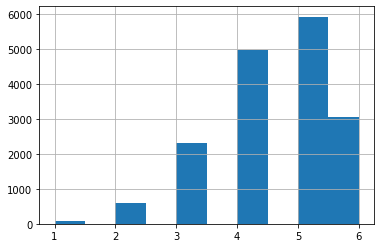

In [67]:
#group event=offer received per person in transactional records
print(transcript_processed[transcript_processed['event']=='offer received'].groupby('person')['event'].count().head())

#visualise offers received per person
transcript_processed[transcript_processed['event']=='offer received'].groupby('person')['event'].count().hist();

We can see above that the offer received per person in the transactional data could range from 1 to 6 offers received. I had the hypothesis that the frequency of offers received per person might result in more effective offers, so decided to engineer a feature offer_received_cnt to account for this frequency.

In [68]:
#get count of offers received per person, put into separate dataset
df_offer_received_cnt=transcript_processed[transcript_processed['event']=='offer received'].groupby(['person','offer_id','time']).count()['event'].reset_index()

#rename columns
df_offer_received_cnt.rename(columns={'event':'offer_received_cnt'},inplace=True)

#drop unnecessary columns
df_offer_received_cnt.drop(['time'], axis=1, inplace=True)

#ensure only unique person-offer_id pairs
df_offer_received_cnt=df_offer_received_cnt.groupby(['person','offer_id']).sum().reset_index()

#### iii. Subtract the transactions which's not related to the offer
I also wondered how many transactions were considered 'invalid' by my definition. Ordinarily, these would be the sum of transactions done by people not in group 1. The objective of offers are to drive purchases, so it would already be the case that users with high spend in their transactions would be flagged as effective_offers.

We've already defined that there are people in groups 3 and 4, where they are separate pools of users who are loyal spenders, and already tend to purchase more, isolated from the the effect of offers.

But for users in group 1 have a high amount of 'invalid spend' outside of the effect of offers, there might be some predictive power onto the effectiveness of offers; since a loyal user might have a higher tendency of taking up an offer.

In my datasets, I had already separated the transactions who are conversions versus transactions who are just the users' normal purchasing behaviour. This is through the completed_offer column, where I checked if a transaction had an offer viewed event prior.

In the cases where offer_completed=1, I had already included them in my effective offers flag for BOGO and Discount offers. However, for those transctions where offer_completed=0, I have not considered them, and this could be a potential feature to include, as a proxy for the 'baseline' level of spending for a user.

The logic is to wonder if there is some baseline level of spending for users who are highly influenced by certain offers (in group 1), and group 2, and if there is some predictive power in this baseline level of 'invalid transactions' that can predict the propensity of a user to take up an offer.

In [69]:
#filter dataset by invalid transactions
# subtract the transactions which's not related to the offer
transactions_not_related=transcript_processed[(transcript_processed['event']=='transaction') & (transcript_processed['completed_offer']==0)].groupby(['person','offer_id'])['amount'].sum().reset_index()
transactions_not_related.rename(columns={'amount':'amount_invalid'},inplace=True)

# Preparing data for implementation

Now we can finally begin with preparing the data for modeling.

a. Merge with temporary datasets created above to include engineered features

b. Drop missing values in gender,income and abnormal age value column for demographic data; convert gender into dummy variables

c. Separate the channel column into categorical variables

d. Treatment of duplicate records

#### a. Merge with temporary datasets created above to include engineered features

In [70]:
# merge to get offers received count and invalid amount transacted 
offers_bogo=offers_bogo.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
offers_bogo=offers_bogo.merge(transactions_not_related[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])

#### b. Drop missing values in gender column for demographic data
Now, we need to check whether dropping the missing values will result in a significant loss in data.

In [71]:
#check % of missing values in dataset
(offers_bogo.isnull().sum()/len(offers_bogo)*100).sort_values(ascending=False).head()

amount_invalid    96.323752
gender             7.057489
income             7.057489
person             0.000000
offer_id           0.000000
dtype: float64

We can see that amount_invalid column has 97% missing data. Since it is so 'sparse' for BOGO offers, it might not have much information after all. We assess this feature again later during the model implementation phase. For now, we fill the missing amount_invalid column with 0.

Meanwhile, we drop the income and gender columns as they are not useful when they are null.

In [72]:
# fill missing values for amount_invalid with 0
offers_bogo['amount_invalid']=offers_bogo['amount_invalid'].fillna(value=0)
offers_bogo.dropna(inplace=True)

#### c. Separate the channel column into categorical variables

In [73]:
#foresee need to reuse dummy variable encoding function
def dummy(df,col):
    df=pd.concat([df[:],pd.get_dummies(df[col],prefix=col)],axis=1)
    df=df.drop(columns=col,axis=1,inplace=False)
    return df

In [74]:
#merge with portfolio to get offer details
offers_bogo=offers_bogo.merge(portfolio,how='left',on='offer_id')

#convert channels into categorical variables
for index, row in offers_bogo.iterrows():
    for channel in ['web', 'email', 'social', 'mobile']:
        if channel in offers_bogo.loc[index, 'channels']:
            offers_bogo.loc[index, channel] = 1
        else:
            offers_bogo.loc[index, channel] = 0

In [75]:
offers_bogo = offers_bogo.drop(['channels'], axis=1, inplace=False)

#convert gender into categorical variables
offers_bogo=dummy(offers_bogo,'gender')

In [76]:
offers_bogo.head()

,person,offer_id,effective_offer,age,income,membership_days,offer_received_cnt,amount_invalid,reward,difficulty,duration,offer_type,web,email,social,mobile,gender_F,gender_M,gender_O
0,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,40,57000.0,39.0,1,0.0,5,5,7,bogo,1.0,1.0,0.0,1.0,0,0,1
1,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1,59,90000.0,824.0,1,0.0,10,10,5,bogo,1.0,1.0,1.0,1.0,1,0,0
2,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,24,60000.0,1071.0,1,0.0,5,5,7,bogo,1.0,1.0,0.0,1.0,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1,24,60000.0,1071.0,1,0.0,5,5,5,bogo,1.0,1.0,1.0,1.0,1,0,0
4,004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d,1,55,74000.0,158.0,1,0.0,5,5,5,bogo,1.0,1.0,1.0,1.0,1,0,0


In [77]:
def prep_offers_df(df):
    
    '''
    inputs:
    - df: original dataframe for modeling 
    
    outputs:
    - Returns dataframe containing engineered features, filled missing values and cleaned and transformed variables (channel and gender)
       
    '''
    #merge to get engineered features 
    df=df.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
    df=df.merge(transactions_not_related[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])
    
    #fill missing values for amount_invalid with 0
    df['amount_invalid']=df['amount_invalid'].fillna(value=0)
    
    #drop income and gender null rows
    df.dropna(inplace=True);
    
    #merge with portfolio to get offer details
    df=df.merge(portfolio,how='left',on='offer_id')

    #convert channels into categorical variables
    for index, row in df.iterrows():
        for channel in ['web', 'email', 'social', 'mobile']:
            if channel in df.loc[index, 'channels']:
                df.loc[index, channel] = 1
            else:
                df.loc[index, channel] = 0
    df = df.drop(['channels'], axis=1, inplace=False)
    
    #convert gender column into dummy variables
    df=dummy(df,'gender')

    return df

In [78]:
#prepare data for offer_discounts
offers_discount=prep_offers_df(offers_discount)

In [79]:
offers_discount.head()

,person,offer_id,effective_offer,age,income,membership_days,offer_received_cnt,amount_invalid,reward,difficulty,duration,offer_type,web,email,social,mobile,gender_F,gender_M,gender_O
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,40,57000.0,39.0,1,0.0,5,20,10,discount,1.0,1.0,0.0,0.0,0,0,1
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,40,57000.0,39.0,1,0.0,3,7,7,discount,1.0,1.0,1.0,1.0,0,0,1
2,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,1,59,90000.0,824.0,2,0.0,2,10,10,discount,1.0,1.0,1.0,1.0,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2,1,24,60000.0,1071.0,1,0.0,3,7,7,discount,1.0,1.0,1.0,1.0,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,1,26,73000.0,566.0,2,0.0,2,10,10,discount,1.0,1.0,1.0,1.0,1,0,0


In [80]:
#merge with portfolio to get offer details
offers_info=offers_info.merge(portfolio,how='left',on='offer_id')

#reset index for offers_info
offers_info = offers_info.reset_index().drop(['index'],axis=1,inplace=False)


#convert channels into categorical variables
for index, row in offers_info.iterrows():
    for channel in ['web', 'email', 'social', 'mobile']:
        if channel in offers_info.loc[index, 'channels']:
            offers_info.loc[index, channel] = 1
        else:
            offers_info.loc[index, channel] = 0
offers_info = offers_info.drop(['channels'], axis=1, inplace=False)

In [81]:
#repurpose function for offers_info
def prep_offers_df(df):
    '''
    inputs:
    - df: dataframe to be transformed 
    
    outputs:
    - Returns dataframe with engineered features and filled missing values, with transformed gender column.
       
    '''
    #merge to get engineered features 
    df=df.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
    df=df.merge(transactions_not_related[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])

    #fill missing values for amount_invalid and offer_received_cnt with 0
    df['amount_invalid']=df['amount_invalid'].fillna(value=0)

    #drop income and gender null rows
    df.dropna(inplace=True);
    
    #convert gender column into dummy variables
    df=dummy(df,'gender')
    return df

In [82]:
offers_info=prep_offers_df(offers_info)
offers_info.head()

,person,offer_id,effective_offer,age,income,membership_days,reward,difficulty,duration,offer_type,web,email,social,mobile,offer_received_cnt,amount_invalid,gender_F,gender_M,gender_O
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,33,72000.0,506.0,0,0,4,informational,1.0,1.0,0.0,1.0,1.0,0.00,0,1,0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,33,72000.0,506.0,0,0,3,informational,0.0,1.0,1.0,1.0,1.0,0.00,0,1,0
2,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,1,59,90000.0,824.0,0,0,3,informational,0.0,1.0,1.0,1.0,1.0,0.00,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,1,24,60000.0,1071.0,0,0,3,informational,0.0,1.0,1.0,1.0,1.0,16.27,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,1,26,73000.0,566.0,0,0,4,informational,1.0,1.0,0.0,1.0,1.0,0.00,1,0,0


# Implementation

Now that the datasets are ready, we can proceed to implementing the model. Our target feature is `effective_offer`

Since we have 3 offer types, there are thus 3 different models to be built. This is effectively a binary classification supervised learning model.

I decided to compare the performance of a simple decision tree classifier model as a baseline model, with an ensemble random forest classifier model. Reason for which we selected tree based models because we also want interpretability of the model. And this project also attempts to predict whether the customer will respond to the different types of offers or not.

Meanwhile, I also selected random forest as an alternate model to compare the baseline model with. Random Forest is an ensemble bagging of decision trees, which aim towards a high accuracy in training the model.

Before we can proceed, we have to make sure that the classes we are predicting for are balanced in each dataset.

--------------------------------------------------------------------------------------------------------------------

In [83]:
#check for class balance in datasets
print(offers_bogo[['person','effective_offer']].groupby('effective_offer').count()/len(offers_bogo))
print(offers_discount[['person','effective_offer']].groupby('effective_offer').count()/len(offers_discount))
print((offers_info[['person','effective_offer']].groupby('effective_offer').count()/len(offers_info)))

                  person
effective_offer         
0                0.17783
1                0.82217
                   person
effective_offer          
0                0.135256
1                0.864744
                 person
effective_offer        
0                0.2611
1                0.7389


We can see that the classes are quite uneven for all three offer types, but not too imbalanced such that it would pose a problem. Hence, we can proceed to implement the models.

A note on model evaluation and validation; since the classes for the all 3 models are imbalanced, I decided to implement both accuracy and f1 score as the model evaluation metric. F1 score provides a better sense of model performance compared to purely accuracy as it takes both false positives and false negatives in the calculation. With an uneven class distribution, F1 may usually be more useful than accuracy.

F1 score gives more weightage to true positive and hence for the Starbucks app here, it would be fine as we would prioritise more on whether offers are effective, and less focus on why offers are ineffective.

### a. Model Implementation
We are creating 3 models to predict the effectiveness of an offer within each type, depending on offer attributes and user demographics.

First, we have to define our target and features variables.

In [84]:
def data_prep(df,col_drop):
    '''
    inputs:
    - df: prepared dataframe for modeling and columns to be dropped
    
    outputs:
    - Returns 2 dataframes - features and target dataframes
    '''
    # Split the data into features and target label
    target = df['effective_offer']
    features = df.drop(columns = col_drop,inplace=False,axis=1)
    return features,target

Next, I split the data into training and test sets. Since the features of my data are all on different scales, I also apply a scaler to ensure my data will all be on the same scale for training.

In [85]:
def model_pipeline(features,target):
    '''
    inputs:
    - features & target dataframe 
    
    outputs:
    - Splits features and target dataframe to train and test sets, performs feature scaling on both datasets.
    - Outputs X_train, X_test, y_train and y_test dataframes
    '''
    
    #split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features,target, test_size=0.20, random_state=42)

    #fit and transform scaling on training data
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)

    #scale test data
    X_test=scaler.transform(X_test)
    return X_train,X_test,y_train, y_test

I am defining the functions here to run my model as I plan to implement 3 different models; hence it would be easier to implement repeatedly. In this function, I define the model scores - F1 score and accuracy, as well as the error (mean squared error).

In [86]:
def train_predict(model, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - model: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: review_scores_rating training set
       - X_test: features testing set
       - y_test: review_scores_rating testing set
    '''
    results = {}
    
    #Fit the learner to the training data and get training time
    start = time() 
    model = model.fit(X_train, y_train)
    end = time() 
    results['train_time'] = end-start
    
    # Get predictions on the test set(X_test)
    start = time() 
    predictions_test = model.predict(X_test)
    predictions_train = model.predict(X_train)
    end = time() 
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
    
    #add training accuracy to results
    results['training_score']=model.score(X_train,y_train)
    
    #add testing accuracy to results
    results['testing_score']=model.score(X_test,y_test)
     
    print("{} trained on {} samples.".format(model.__class__.__name__, len(y_train)))
    print("MSE_train: %.4f" % mean_squared_error(y_train,predictions_train))
    print("MSE_test: %.4f" % mean_squared_error(y_test,predictions_test))
    print("Training accuracy:%.4f" % results['training_score'])
    print("Test accuracy:%.4f" % results['testing_score'])
    print(classification_report(y_test, predictions_test,digits=4))
    return results

In [87]:
def run_model(clf1,clf2,name):
    '''
    inputs:
    - clf1: first classifier model
    - clf2: 2nd classifier model for comparison
    - name: name of models for comparison
    
    outputs:
    - Dataframe of results from model training and prediction
    '''
    
    # Collect results on the learners
    results = {}
    for clf in [clf1, clf2]:
        clf_name = clf.__class__.__name__ + '_' +name
        results[clf_name] = {}
        results[clf_name]= train_predict(clf, X_train, y_train, X_test, y_test)
    return pd.DataFrame(results)

#### i. BOGO offers model
First we try to build the BOGO offers model. I initialize the models with some randomly chosen parameters to check the initial performance. If performance needs to be improved further, I will attempt Grid Search to find the optimal parameters.

In [88]:
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model - baseline is DT model, bogo_1 model is RF model
baseline = DecisionTreeClassifier(criterion='entropy',max_depth=5,random_state=2,min_samples_split=90,min_samples_leaf=50)
bogo_1 = RandomForestClassifier(random_state=2,max_depth= 11, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=20)

results=run_model(baseline,bogo_1,'bogo_1')

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1777
MSE_test: 0.1782
Training accuracy:0.8223
Test accuracy:0.8218
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       438
           1     0.8218    1.0000    0.9022      2020

    accuracy                         0.8218      2458
   macro avg     0.4109    0.5000    0.4511      2458
weighted avg     0.6754    0.8218    0.7414      2458

RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1672
MSE_test: 0.1717
Training accuracy:0.8328
Test accuracy:0.8283
              precision    recall  f1-score   support

           0     0.6667    0.0731    0.1317       438
           1     0.8315    0.9921    0.9047      2020

    accuracy                         0.8283      2458
   macro avg     0.7491    0.5326    0.5182      2458
weighted avg     0.8022    0.8283    0.7670      2458



C:\Users\farhad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\farhad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\farhad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1

The accuracy for Random Forest Classifier (RF) model actually ends up outperforming the Decision Tree Classifier (DT) model slightly, but overall the performance for both models is about the same (82.83% vs 82.18% respectively in terms of accuracy). Accuracy for a first attempt is quite good, more than 80%. We will try tuning the model for better accuracy

However, in terms of the F1 score, both models are below 80%, with the Random Forest model performing better compared to the Decision Tree Classifier, with 76.70% vs. 74.14%.

The results would indicate that RF model is doing slightly better compared to DT at not misclassifying negative events as positive (meaning, misclassifying people on which offers are ineffective, as people on which offers would be effective).

Our model is predicting the positive case (i.e. where an offer is effective) more accurately compared to predicting the negative cases (i.e. where an offer is ineffective), which is expected given the uneven classes. We are perhaps not as concerned with these misclassification since we don't mind sending people more offers than they would have liked; we would rather not miss anyone on which an offer would have been effective.

Given this case, I will go with the RF model.

Since I aim to analyse the drivers of an effective offer, I will check the feature importances for the models after I have selected the best model from refinement.

#### ii. Discount offers model
I repeat the same steps above but with my offer_discounts dataset.

In [89]:
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_discount,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
discount_1 = RandomForestClassifier(random_state=2,max_depth= 20, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)
results=pd.concat([results[:],run_model(baseline,discount_1,'discount_1')],axis=1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1371
MSE_test: 0.1277
Training accuracy:0.8629
Test accuracy:0.8723
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       325
           1     0.8723    1.0000    0.9318      2220

    accuracy                         0.8723      2545
   macro avg     0.4361    0.5000    0.4659      2545
weighted avg     0.7609    0.8723    0.8128      2545



C:\Users\farhad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\farhad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\farhad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1

RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1265
MSE_test: 0.1293
Training accuracy:0.8735
Test accuracy:0.8707
              precision    recall  f1-score   support

           0     0.3889    0.0215    0.0408       325
           1     0.8742    0.9950    0.9307      2220

    accuracy                         0.8707      2545
   macro avg     0.6315    0.5083    0.4858      2545
weighted avg     0.8122    0.8707    0.8171      2545



This time, the Decision Tree Classifier model also has a better performance compared to the Random Forest Classifier in terms of accuracy (87.07% vs 87.23%), and the F1 score is also lower (81.71% vs 81.28%).

In [90]:
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
info_1 = RandomForestClassifier(random_state=5,criterion='gini',max_depth= 20, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)

results=pd.concat([results[:],run_model(baseline,info_1,'info_1')],axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2489
MSE_test: 0.2598
Training accuracy:0.7511
Test accuracy:0.7402
              precision    recall  f1-score   support

           0     0.4722    0.1915    0.2725       355
           1     0.7709    0.9271    0.8418      1042

    accuracy                         0.7402      1397
   macro avg     0.6216    0.5593    0.5572      1397
weighted avg     0.6950    0.7402    0.6972      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2267
MSE_test: 0.2513
Training accuracy:0.7733
Test accuracy:0.7487
              precision    recall  f1-score   support

           0     0.5263    0.1127    0.1856       355
           1     0.7615    0.9655    0.8515      1042

    accuracy                         0.7487      1397
   macro avg     0.6439    0.5391    0.5185      1397
weighted avg     0.7018    0.7487    0.6823      1397



The performance for these models are worse compared to the other 2 datasets, with accuracy below 80% for both models, but RF model still performing better. The F1 score is also worse, at 68.23% RF Classifier, worse than the DT model at 69.72%.

One potential reason for the worse performance is perhaps due to the fact that I had the key assumption to assign the conversion events to be transactions that only occur after an offer is viewed and within the specified duration; I might have missed out on some valuable information by removing those transactions that occur regardless. We can see this from how the overall sample dataset is smaller (about half) the datasets for the other 2 offers, with only about 5K samples compared to about 10K for both BOGO and discount respectively.

### b. Refinement
In refining the model, I will first try parameter tuning for the 3 RF models, before experimenting with removing or adding features to improve model performance.

In [91]:
#define function to find best model results for each offer type
def best_model(offer_type):
    '''
    input:
    - offer_type: string of offer type name
    output:
    - dataframe containing results of best model so far
    
    '''
    print('For ' + offer_type + ' RF model:')
    return results.transpose()[results.transpose()['testing_score']==results.transpose()[results.transpose().index.str.contains("RandomForestClassifier_"+offer_type)]['testing_score'].max()]

#### i. Grid Search to discover optimal parameters
I decided to do GridSearch to determine what would be the optimal parameters for the model.

For all three offers, the Random Forest model had relatively good performance, so I used Grid Search on this to determine the best parameters.

In [92]:
#define Grid Search function
def rand_forest_param_selection(X,y):
    '''
    input:
    - X,y: training datasets for X and y
    output:
    - dictionary with best parameters for random forest model
    '''
    
    param_grid={'max_features': ['auto', 'sqrt'],
                'max_depth' : [5,10,15,20],
                'n_estimators': [25,30,40,50],
                'min_samples_split': [2, 10, 20],
                'min_samples_leaf': [2, 10,15, 20],
                }
    grid_search = GridSearchCV(RandomForestClassifier(random_state=2), param_grid)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [93]:
#define BOGO dataset
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#run Grid Search - commented out because takes to long to run, but have put in selected params in model
rand_forest_param_selection(X_train, y_train)

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 20,
 'n_estimators': 25}

Now that we have the optimal parameters for the BOGO model, I run my model again with the new parameters, keeping the DecisionTree baseline model with the same parameters as comparison.

In [94]:
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
bogo_2 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=25,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,bogo_2,'bogo_2')],axis=1)

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1777
MSE_test: 0.1782
Training accuracy:0.8223
Test accuracy:0.8218
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       438
           1     0.8218    1.0000    0.9022      2020

    accuracy                         0.8218      2458
   macro avg     0.4109    0.5000    0.4511      2458
weighted avg     0.6754    0.8218    0.7414      2458



C:\Users\farhad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\farhad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\farhad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1

RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1558
MSE_test: 0.1713
Training accuracy:0.8442
Test accuracy:0.8287
              precision    recall  f1-score   support

           0     0.6104    0.1073    0.1825       438
           1     0.8358    0.9851    0.9043      2020

    accuracy                         0.8287      2458
   macro avg     0.7231    0.5462    0.5434      2458
weighted avg     0.7956    0.8287    0.7757      2458



In [95]:
results[['RandomForestClassifier_bogo_1','RandomForestClassifier_bogo_2']]

,RandomForestClassifier_bogo_1,RandomForestClassifier_bogo_2
train_time,0.098970,0.133644
pred_time,0.028923,0.039892
training_score,0.832842,0.844236
testing_score,0.828316,0.828723


In [96]:
#find best model so far for BOGO offer type
best_model('bogo')

For bogo RF model:


,train_time,pred_time,training_score,testing_score
RandomForestClassifier_bogo_2,0.133644,0.039892,0.844236,0.828723


The accuracy for the RF model increased slightly - from 82.8316% to 82.8723%, and the F1 score increased from 76.70% to 77.57%. This is a good performance increase but minimal, which indicates that perhaps there's not much that can be done to improve the performance of the model with parameter tuning.

So I will have to explore other avenues with the features to improve the performance of the model further.

In [97]:
#define discount dataset
features,target=data_prep(offers_discount,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

# run Grid Search - commented out because takes to long to run, but have put in selected params in model
rand_forest_param_selection(X_train, y_train)

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 30}

In [98]:
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
discount_2 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 2,n_estimators=30,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,discount_2,'discount_2')],axis=1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1371
MSE_test: 0.1277
Training accuracy:0.8629
Test accuracy:0.8723
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       325
           1     0.8723    1.0000    0.9318      2220

    accuracy                         0.8723      2545
   macro avg     0.4361    0.5000    0.4659      2545
weighted avg     0.7609    0.8723    0.8128      2545



C:\Users\farhad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\farhad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\farhad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1

RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1277
MSE_test: 0.1261
Training accuracy:0.8723
Test accuracy:0.8739
              precision    recall  f1-score   support

           0     0.6250    0.0308    0.0587       325
           1     0.8754    0.9973    0.9324      2220

    accuracy                         0.8739      2545
   macro avg     0.7502    0.5140    0.4955      2545
weighted avg     0.8435    0.8739    0.8208      2545



In [99]:
results[['RandomForestClassifier_discount_1','RandomForestClassifier_discount_2']]

,RandomForestClassifier_discount_1,RandomForestClassifier_discount_2
train_time,0.118680,0.168552
pred_time,0.034907,0.055866
training_score,0.873465,0.872286
testing_score,0.870727,0.873870


In [100]:
#find best model so far for discount offer type
best_model('discount')

For discount RF model:


,train_time,pred_time,training_score,testing_score
RandomForestClassifier_discount_2,0.168552,0.055866,0.872286,0.87387


The accuracy of the model increaased slightly, from 87.07% to 87.39%, and the F1 score improved from 81.71% to 82.08%. The good thing is that now both the accuracy and the F1 score for the RF model is better than the DT model.

But because the increase was minimal, again we can conclude that tuning the parameters won't really improve the performance of the model significantly.

In [101]:
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#run Grid Search - commented out because takes to long to run, but have put in selected params in model
rand_forest_param_selection(X_train, y_train)

{'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 20,
 'min_samples_split': 2,
 'n_estimators': 25}

In [102]:
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
info_2 = RandomForestClassifier(random_state=2,max_depth= 15, max_features= 'auto',min_samples_split= 2,n_estimators=25,min_samples_leaf=20)

results=pd.concat([results[:],run_model(baseline,info_2,'info_2')],axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2489
MSE_test: 0.2598
Training accuracy:0.7511
Test accuracy:0.7402
              precision    recall  f1-score   support

           0     0.4722    0.1915    0.2725       355
           1     0.7709    0.9271    0.8418      1042

    accuracy                         0.7402      1397
   macro avg     0.6216    0.5593    0.5572      1397
weighted avg     0.6950    0.7402    0.6972      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2444
MSE_test: 0.2477
Training accuracy:0.7556
Test accuracy:0.7523
              precision    recall  f1-score   support

           0     0.6047    0.0732    0.1307       355
           1     0.7570    0.9837    0.8556      1042

    accuracy                         0.7523      1397
   macro avg     0.6808    0.5285    0.4931      1397
weighted avg     0.7183    0.7523    0.6714      1397



In [103]:
results[['RandomForestClassifier_info_1','RandomForestClassifier_info_2']]

,RandomForestClassifier_info_1,RandomForestClassifier_info_2
train_time,0.073844,0.073220
pred_time,0.019947,0.023491
training_score,0.773321,0.755595
testing_score,0.748747,0.752326


In [104]:
#find best model so far for info offer type
best_model('info')

For info RF model:


,train_time,pred_time,training_score,testing_score
RandomForestClassifier_info_2,0.07322,0.023491,0.755595,0.752326


Again we see some improvement in accuracy for RF model, from 74.87% to 75.23%, and slight decrease in F1 score from 68.23% to 67.14%. This improvement is minimal,so we look into improving the feature selection of the model.

#### ii. Removing sparse features e.g. amount_invalid¶
In terms of feature selection, I wanted to try and see if removing the amount_invalid variable, which we had noted as being sparse, hence may not be useful in predicting the effectiveness of offers, would help.

I removed the feature from my data prep and retrained the model using the same optimal parameters found via GridSearch, with the DT model as a baseline

In [105]:
#add amount_invalid variable to drop_cols_prep list
drop_cols_prep=['person','offer_id','effective_offer','offer_type','amount_invalid']

#train BOGO model
features,target=data_prep(offers_bogo,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
bogo_3 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 20,n_estimators=25,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,bogo_3,'bogo_3')],axis=1)

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1764
MSE_test: 0.1745
Training accuracy:0.8236
Test accuracy:0.8255
              precision    recall  f1-score   support

           0     0.5283    0.1918    0.2814       438
           1     0.8460    0.9629    0.9007      2020

    accuracy                         0.8255      2458
   macro avg     0.6872    0.5773    0.5910      2458
weighted avg     0.7894    0.8255    0.7903      2458

RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1526
MSE_test: 0.1713
Training accuracy:0.8474
Test accuracy:0.8287
              precision    recall  f1-score   support

           0     0.5955    0.1210    0.2011       438
           1     0.8375    0.9822    0.9041      2020

    accuracy                         0.8287      2458
   macro avg     0.7165    0.5516    0.5526      2458
weighted avg     0.7944    0.8287    0.7788      2458



In [106]:
results[['RandomForestClassifier_bogo_2','RandomForestClassifier_bogo_3']]

,RandomForestClassifier_bogo_2,RandomForestClassifier_bogo_3
train_time,0.133644,0.155622
pred_time,0.039892,0.043879
training_score,0.844236,0.847390
testing_score,0.828723,0.828723


In [107]:
#find best model so far for BOGO offer type
best_model('bogo')

For bogo RF model:


,train_time,pred_time,training_score,testing_score
RandomForestClassifier_bogo_2,0.133644,0.039892,0.844236,0.828723
RandomForestClassifier_bogo_3,0.155622,0.043879,0.847390,0.828723


Model accuracy and F1 score did remain the same, so I wont leave the amount_invalid feature out of my model.

In [108]:
#train discount model
features,target=data_prep(offers_discount,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
discount_3 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 2,n_estimators=30,min_samples_leaf=2)

results=pd.concat([results[:],run_model(baseline,discount_3,'discount_3')],axis=1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1371
MSE_test: 0.1277
Training accuracy:0.8629
Test accuracy:0.8723
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       325
           1     0.8723    1.0000    0.9318      2220

    accuracy                         0.8723      2545
   macro avg     0.4361    0.5000    0.4659      2545
weighted avg     0.7609    0.8723    0.8128      2545



C:\Users\farhad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\farhad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\farhad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1

RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1257
MSE_test: 0.1289
Training accuracy:0.8743
Test accuracy:0.8711
              precision    recall  f1-score   support

           0     0.4118    0.0215    0.0409       325
           1     0.8742    0.9955    0.9309      2220

    accuracy                         0.8711      2545
   macro avg     0.6430    0.5085    0.4859      2545
weighted avg     0.8152    0.8711    0.8173      2545



In [109]:
results[['RandomForestClassifier_discount_2','RandomForestClassifier_discount_3']]

,RandomForestClassifier_discount_2,RandomForestClassifier_discount_3
train_time,0.168552,0.167592
pred_time,0.055866,0.056806
training_score,0.872286,0.874251
testing_score,0.873870,0.871120


In [110]:
#find best model so far for discount offer type
best_model('discount')

For discount RF model:


,train_time,pred_time,training_score,testing_score
RandomForestClassifier_discount_2,0.168552,0.055866,0.872286,0.87387


Accuracy of the model didnt increased. In this case, I wont remove the amount_invalid feature for the discount model.

In [111]:
#train info model
features,target=data_prep(offers_info,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
info_3 = RandomForestClassifier(random_state=2,max_depth= 15, max_features= 'auto',min_samples_split= 2,n_estimators=25,min_samples_leaf=20)

results=pd.concat([results[:],run_model(baseline,info_3,'info_3')],axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2489
MSE_test: 0.2598
Training accuracy:0.7511
Test accuracy:0.7402
              precision    recall  f1-score   support

           0     0.4722    0.1915    0.2725       355
           1     0.7709    0.9271    0.8418      1042

    accuracy                         0.7402      1397
   macro avg     0.6216    0.5593    0.5572      1397
weighted avg     0.6950    0.7402    0.6972      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2469
MSE_test: 0.2462
Training accuracy:0.7531
Test accuracy:0.7538
              precision    recall  f1-score   support

           0     0.6341    0.0732    0.1313       355
           1     0.7574    0.9856    0.8565      1042

    accuracy                         0.7538      1397
   macro avg     0.6958    0.5294    0.4939      1397
weighted avg     0.7261    0.7538    0.6723      1397



In [112]:
results[['RandomForestClassifier_info_2','RandomForestClassifier_info_3']]

,RandomForestClassifier_info_2,RandomForestClassifier_info_3
train_time,0.073220,0.080747
pred_time,0.023491,0.020944
training_score,0.755595,0.753089
testing_score,0.752326,0.753758


In [113]:
#find best model so far for info offer type
best_model('info')

For info RF model:


,train_time,pred_time,training_score,testing_score
RandomForestClassifier_info_3,0.080747,0.020944,0.753089,0.753758


Accuracy and F1 score of the model actually increased here for info model but not to much extent, so I will also keep the feature in.

#### iv. Discussion on best models and feature importances:

Now that I am done with refining the 3 models, we can check the results for our best models for all 3 and check the feature importances to see the top drivers of effectiveness of offers.

In [114]:
#get best model overall for bogo,discount and info offers
best_model('bogo').append([best_model('discount'),best_model('info')]).transpose()

For bogo RF model:
For discount RF model:
For info RF model:


C:\Users\farhad\AppData\Local\Temp\ipykernel_13432\285693750.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  best_model('bogo').append([best_model('discount'),best_model('info')]).transpose()


,RandomForestClassifier_bogo_2,RandomForestClassifier_bogo_3,RandomForestClassifier_discount_2,RandomForestClassifier_info_3
train_time,0.133644,0.155622,0.168552,0.080747
pred_time,0.039892,0.043879,0.055866,0.020944
training_score,0.844236,0.847390,0.872286,0.753089
testing_score,0.828723,0.828723,0.873870,0.753758


Overall, we can see that the top performing models are the 2nd model (with GridSearch to find optimal model parameters and removing amount_invalid column) for predicting effectiveness of BOGO and discount offers, and informational offers.

In order to find the most influential drivers of an effective offer, we can check the feature importances of our best models above.

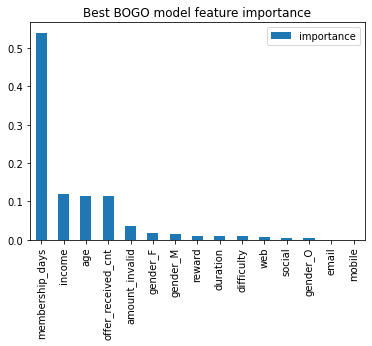

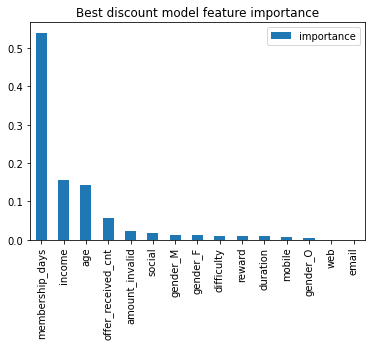

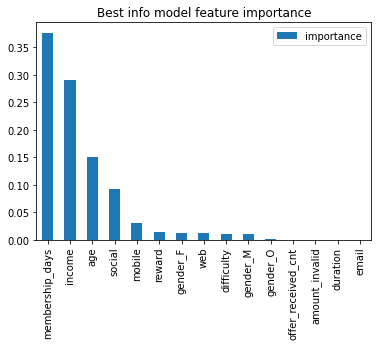

In [115]:
#show feature importance
#BOGO 3 model
#prepare data same as BOGO 3 state
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_bogo,drop_cols_prep)

feature_importances = pd.DataFrame(bogo_2.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best BOGO model feature importance')
plt.show()

#discount 3 model
feature_importances = pd.DataFrame(discount_2.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best discount model feature importance')
plt.show()

#info_2 model
#prepare data similar to info_2 state
drop_cols_prep=['person','offer_id','effective_offer','offer_type']
features,target=data_prep(offers_discount,drop_cols_prep)
#print feature importance
feature_importances = pd.DataFrame(info_2.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best info model feature importance')
plt.show()

Checking on the feature importance to analyse the main drivers of an effective offer, we can see that the most important driver of effective offers across all three are the tenure of membership i.e. the longer the customer as a member of Starbucks, the more likely (s)he will respond to the offer they receive. And, the 2nd most important feature is income for each of the three models.

For a BOGO offer, the membership tenure is the most important feature, and the other variables are a lot smaller in proportions. Income, age and offer_received_cnt are the 2nd, 3rd and 4th most important features, but their proportions are very small.

For a discount offer, after the membership tenure, age and income are the next most important variables. But it is still very small in proportions.

The feature importances for the informational offer models are more distributed compared to the BOGO and discount models, with income being the 2nd most important feature. Age is the third and social channel interestingly being the 4th.

-------------------------------------------------------------------------------------------------------------

In [116]:
results

,DecisionTreeClassifier_bogo_1,RandomForestClassifier_bogo_1,DecisionTreeClassifier_discount_1,RandomForestClassifier_discount_1,DecisionTreeClassifier_info_1,RandomForestClassifier_info_1,DecisionTreeClassifier_bogo_2,RandomForestClassifier_bogo_2,DecisionTreeClassifier_discount_2,RandomForestClassifier_discount_2,DecisionTreeClassifier_info_2,RandomForestClassifier_info_2,DecisionTreeClassifier_bogo_3,RandomForestClassifier_bogo_3,DecisionTreeClassifier_discount_3,RandomForestClassifier_discount_3,DecisionTreeClassifier_info_3,RandomForestClassifier_info_3
train_time,0.014959,0.098970,0.013962,0.118680,0.007978,0.073844,0.013957,0.133644,0.013964,0.168552,0.007984,0.073220,0.013962,0.155622,0.012964,0.167592,0.010970,0.080747
pred_time,0.000998,0.028923,0.000998,0.034907,0.000999,0.019947,0.000999,0.039892,0.000997,0.055866,0.000995,0.023491,0.000998,0.043879,0.001994,0.056806,0.001000,0.020944
training_score,0.822261,0.832842,0.862855,0.873465,0.751119,0.773321,0.822261,0.844236,0.862855,0.872286,0.751119,0.755595,0.823583,0.847390,0.862855,0.874251,0.751119,0.753089
testing_score,0.821806,0.828316,0.872299,0.870727,0.740157,0.748747,0.821806,0.828723,0.872299,0.873870,0.740157,0.752326,0.825468,0.828723,0.872299,0.871120,0.740157,0.753758


## Conclusion

Overall, I found this project challenging, mainly due to the structure of the data in the `transcript` dataset. I had started out with 2 business questions:

1. What are the main features influencing the effectiveness of an offer on the Starbucks app?
2. Could the data provided, namely offer characteristics and user demographics, predict whether a user would take up an offer?

### a. Reflection:

#### i. Question 1 findings:
For Question 1, the feature importance given by all 3 models were that the tenure of a member is the biggest predictor of the effectiveness of an offer.

For all three models, the top 3 variables were the same - membership tenure, income and age. However, income and age switched orders depending on offer type. 

For BOGO and discount offers, the distribution of feature importances were relatively equal. However, for informational offers, the distribution is slightly more balanced, with income the second most important variable.

#### ii. Question 2 findings:

My decision to use 3 separate models to predict the effectiveness of each offer type ended up with good accuracy for the BOGO and discount models (82.87% for BOGO and 87.38% for discount), while slightly less accurate performance for informational offers (75.23%). However, I would regard 75% as acceptable in a business setting, as for informational offers, there is no cost involved to inform users of a product.

Meanwhile, for BOGO and discount models, I am quite happy with the 80% and above accuracy, as in a business setting that would be acceptable to show offers to people, even if the model misclassifies a few, the overall revenue increase might justify the few mistakes. 

### b. Main challenges and potential improvement:

When analysing and building the machine learning models to answer the above questions, reflections on my main challenges and findings are as follows:

#### i. Attribution framework for assigning offer_ids for transactions:

In order to answer Question 1, I had to first define what an 'effective offer' means using the transactional records. This proved to be the trickiest portion of the project. I had to define a funnel for what what an effective conversion would look like, as we had data on both effective and noneffective conversions. Thus, I was desigining an attribution model for the conversion events (`offer completed` and `transaction` events) based on the events that occurred prior for each person.

I ended up having to separate the users into 4 different pools, based on their actions in the transcript data:

- Group 1: People who are influenced by offers and thus purchase/complete the offer(successful/effective conversion of offer)
- Group 2: People who receive and an offer but is not influenced and thus no conversion event (ineffective conversion of offer)
- Group 3: People who have conversion events but was not actually influenced by an offer
- Group 4: People who receive offers but no views or action taken

Even after separating the groups, it was challenging to assign the people in group 3 based on the transactional data. I had to define the event space where the right sequence of events would occur before I could assign an offer id to transactions (which did not have an offer_id), essentally designing a event/sequence-based attribution window.

#### ii. Feature engineering:

Deciding on what features to re-engineer and how to engineer for an effective model. At the end, our reengineered feature of membership tenure was indeed the most important feature.

#### iii. Model implementation decisions:

I had made the decision to build 3 separate models depending on offer types based on my definition of the problem statement - as I wanted to discover what would drive an effective offer, I thought it made more sense to remove noise from the data by separating the data into the offer types. My decision ended up to be quite a good one as the single BOGO and discount models got good performance in testing scores. 

For the info model, the accuracy was slightly worse as we had less records overall. As elaborated above, I believe that if we had more data, I could have gotten the accuracy higher.

An additional note on model selection - I selected tree-based models as I wanted to assess feature importance, but I could have extended this study further by testing a parametric/ regression model (e.g. logistic regression for classification tasks). The weights of the coefficients from a regression model might have been interesting to contrast with the feature importance of a tree-based model, given that both models have different ways of analysing the data. The feature `membership_tenure_days` might not have been the highest weighted feature, in contrast to how it was in this study.

----------------------------------------------------------------------------------------------------------------------


# Further Improvements and Experimentation

Due to time reasons, I couldn't get a chance to try some other enhancement in the step of model tuning. For example, probably, I can do some more experiment on feature engineering step to see if any other new features can improve the model, also I could also try to reduce some feature to see how it will affect the model performance.

Also, so far the analysis is focused more on customer's who successfully finish the transaction after they received the offer, there should be more insight for the other cases where the customer finishes the transactions regardless of the offer. If we could get any insight into those cases, maybe we can send out more offers to those customers.

In addition, I was thinking if I could do some unsupervised learning on clustering the customers based on information we are given, to see if there are any specific characteristics on a group of customers who will be more likely to respond to the offer.